# load data

In [1]:
import pandas as pd
import re
import json

# Load the CSV file into a DataFrame
df = pd.read_csv("/Users/yehocoh/Projects/Python/esg_project/df_500_url.csv")

In [2]:
# Handle NaN values
df['pdf_text'].fillna('', inplace=True)

# Simple sentence tokenizer based on regex
def simple_sent_tokenize(text):
    sentences = re.split('(?<!\\w\\.\\w.)(?<![A-Z][a-z]\\.)(?<=\\.|\\?)\\s', text)
    return [sent.strip() for sent in sentences if sent]

# Tokenize 'pdf_text' using the simple tokenizer
df['sentences'] = df['pdf_text'].apply(simple_sent_tokenize)

# Expand the DataFrame so that each row contains a single sentence
df_exploded = df.explode('sentences')
df_exploded['sentences'].fillna('', inplace=True)

# Extract company name and year from pdf_name
df_exploded['company_name'] = df_exploded['pdf_name'].str.rsplit('-', n=1).str[0]

In [3]:
def extract_year(pdf_name):
    # Extract the year using regex
    year = re.search(r'(\d{4})', pdf_name)
    if year:
        year = int(year.group(1))
        # Check if the year falls within the desired range
        if 2000 <= year <= 2023:
            return year
    # Return NaN for anything else
    return float('nan')

# Apply the updated extraction function
df_exploded['report_year'] = df_exploded['pdf_name'].apply(extract_year)

In [4]:
df_exploded.sample(5)

,pdf_name,url,page_count,text_len,table_of_content,pdf_text,sentences,company_name,report_year
470,2016_MS_Sustainability_Report.pdf,https://sust-reports-prod-v1.s3.us-east-2.amaz...,16,68149,[],"At Morgan Stanley, we advise, originate, trade...",The prospectus contains this and \nother infor...,2016_MS_Sustainability_Report.pdf,2016.0
293,2022%2520Sustainability%2520Report_FINAL.pdf,https://sust-reports-prod-v1.s3.us-east-2.amaz...,32,44850,[],����������������\n��������������\n�����������\...,"Managing, Diverting, and Reducing Waste\nThe U...",2022%2520Sustainability%2520Report_FINAL.pdf,2022.0
78,aci-sustainabilityreport.pdf,https://sust-reports-prod-v1.s3.us-east-2.amaz...,34,34274,[],1\nSUSTAINABILITY \nREPORT\nA REVIEW OF ACI’S ...,"Among the ESG reporting frameworks, we primari...",aci,NaN
26,NYSE_ABT_2012.pdf,https://sust-reports-prod-v1.s3.us-east-2.amaz...,143,372330,[],INTERIM REPORT\n2011-2012 Interim Global Citiz...,And since the biosensor test required less blo...,NYSE_ABT_2012.pdf,2012.0
241,albemarle_2019_sustainability_report_2018_acti...,https://sust-reports-prod-v1.s3.us-east-2.amaz...,104,140121,"[[1, 'Cover', 1], [1, 'Table of Contents', 2],...",2\nTable of Contents\n1.1 Statement from the ...,"34\nThrough a series of communications, and le...",albemarle_2019_sustainability_report_2018_acti...,2019.0


# classify_sentence func

In [5]:
# Function to classify sentences
def classify_sentence(sentence):
    # Classification patterns and keywords
    quantitative_evidence_keywords = [
    r'\d+(\.\d+)?%',  # Percentage values
    r'\d+',  # Numerical values
    'quantitatively', 
    'statistics show', 
    'data reveals',
    'numerical evidence'
    ]

    action_evidence_keywords = [
        'achieved', 
        'completed', 
        'implemented', 
        'established', 
        'reduced', 
        'increased', 
        'decreased', 
        'maintained',
        'enacted', 
        'put into place', 
        'carried out', 
        'executed',
        'realized', 
        'fulfilled'
    ]

    suggestive_evidence_keywords = [
        'indication', 
        'suggests', 
        'indicative', 
        'evidence shows', 
        'demonstrates', 
        'proves', 
        'illustrates',
        'hints at', 
        'alludes to', 
        'signs of', 
        'seems to', 
        'appears to', 
        'based on observations'
    ]

    intention_keywords = [
        'plan to', 
        'intend to', 
        'aim to', 
        'commitment', 
        'in the future', 
        'will', 
        'going to', 
        'prospective',
        'hope to', 
        'aspires to', 
        'looks forward to', 
        'setting out to'
    ]

    if any(re.search(pattern, sentence, re.I) for pattern in quantitative_evidence_keywords):
        return 'Quantitative Evidence'
    if any(word in sentence.lower() for word in action_evidence_keywords):
        return 'Action Evidence'
    if any(word in sentence.lower() for word in suggestive_evidence_keywords):
        return 'Suggestive Evidence'
    if any(word in sentence.lower() for word in intention_keywords):
        return 'Intention'
    return 'Other'

In [6]:
# Apply the classification function to each sentence
df_exploded['classification'] = df_exploded['sentences'].apply(classify_sentence)

In [7]:
# Prepare the required DataFrame for CSV export
df_export = df_exploded[['pdf_name', 'company_name', 'report_year', 'pdf_text', 'sentences', 'classification']]

# Export to CSV
df_export.to_csv("classified_sentences_df.csv", index=False)

In [ ]:
# Prepare JSON structure and export
json_data = df_export[['pdf_name', 'company_name', 'report_year', 'sentences', 'classification']].to_dict(orient='records')
with open("classified_sentences.json", 'w') as json_file:
    json.dump(json_data, json_file)

# validation (using chat gpt)

In [8]:
sentences = [
    "Our PCI target for 2028 is 71 g CO2e/MJ, a > 5% decrease from 2016.",
    "In collaboration with Pavilion Energy and QatarEnergy, we jointly developed a liquefied natural gas (LNG) carbonfootprinting methodology for delivered cargoes to help advance a standard for GHG product-level accounting.",
    "This methodology is expected to improve accuracy and build stakeholder confidence in data reliability.",
    "In early 2022, we announced a one-year pilot with Project Canary to enhance our ability to demonstrate transparency in how we are lowering methane emissions in our operations.",
    "Project Canary will use its comprehensive TrustWell Certification program to review and analyze the environmental and social performance aspects of individual wells and facilities in Colorado and Texas.",
    "The PCI metric, which includes Scope 1, 2 and 3, represents the carbon intensity across the full value chain associated with bringing products to market.",
    "Chevron's efforts to achieve our 2028 Upstream methane intensity target of 2.0 kg CO2e/boe include facility design, GHG reduction projects and exploring emerging technology to identify opportunities to further lower emissions.",
    "Our planned GHG reduction projects include opportunities to reduce venting, such as a nitrogen blanket system for the tank farm at Tengizchevroil (TCO), and to reduce flaring, which also reduces methane emissions.",
    "Our standard facility design in the Permian Basin includes methane emission controls, such as vapor recovery units at central tank batteries and pneumatic controllers that utilize compressed air instead of natural gas.",
    "We are committed to further improving methane detection and direct measurement through our global methane detection campaign, which focuses on scaling up proven and emerging detection technologies and modes of deployment, such as satellites, aircraft and drones.",
    "To date, we have completed campaigns in Argentina, the Denver-Julesburg Basin, the Gulf of Mexico, the Permian Basin and TCO.",
    "We are active participants in multiple partnerships and associations focused on methane emissions.",
    "Chevron is a founding member of the Collaboratory to Advance Methane Science (CAMS), a joint industry project to conduct peer-reviewed research around methane emissions.",
    "Recent CAMS projects include an aerial survey to understand sources in the Permian Basin and the first measurement study of methane emissions from LNG transport activities.",
    "Chevron is also a founding partner of the Environmental Partnership, an industry initiative aimed at accelerating the adoption of practices that reduce methane emissions.",
    "To date, companies in this initiative have conducted more than 770,000 leak detection surveys and replaced more than 27,000 pneumatic controllers with lower- or non-emitting technologies.",
    "Recently, the Environmental Partnership collaborated with several aerial survey technology providers, including the NASA Jet Propulsion Laboratory/University of Arizona, GHGSat, Bridger Photonics and Kairos Aerospace.",
    "We're investing to reduce methane emissions and flaring.",
    "Improving methane detection, rethinking facility designs, optimizing equipment and deploying new operational practices are a few examples of the projects underway to lower emissions.",
    "Completion operations flow back to permanent facilities that have equipment to capture entrained gas.",
    "Since 2011, standard facility designs have included compressed air for pneumatic controllers, which eliminate natural gas venting for that application.",
    "Standard designs for tank batteries and compressor stations include Vapor Recovery Units, which gather emissions that can be reused onsite or sold to third parties.",
    "Flaring intensity was 79% less than Permian Basin average in 2020 due to infrastructure planning to create gas-take away capacity.",
    "OurApologies for the cutoff in the previous message. Here's the continuation:",
    "Our Mid-Continent business unit has piloted eight advanced methane detection solutions since 2016 and selected an aerial laser-based methane scanning technology for broader deployment in the Permian.",
    "Aircraft-based solutions help us and other nearby operators cost-effectively screen assets for methane emissions across a wide geographic footprint in the Permian.",
    "Early in 2021, I was asked to serve as project manager for Chevron's methane detection campaign, which is tasked with deploying methane detection technology to cover 80% of our equity emissions.",
    "Our team works with business units across Chevron's asset classes to design tailored methane detection solutions to accommodate operational needs, policy concerns and regulatory protocols.",
    "We are experimenting with a variety of technologies to expand our methane detection capabilities, including deploying airborne sensors using satellites, aircraft and drones.",
    "In addition to working within Chevron's business units, we also collaborate with regulators, universities and other operators to evaluate equipment and share best practices.",
    "I'm especially proud of our work with the Gulf of Mexico business unit, where we became one of the first operators to deploy a methane detection solution offshore using drones.",
    "Offshore is especially challenging because ocean water can confuse detection technology and create false readings.",
    "In addition, platforms have layered equipment, which can make it difficult to identify the source of emissions from overhead sensors alone.",
    "To solve this challenge, we combined emissions detection equipment from our San Joaquin Valley business unit with drones used offshore and developed a new flight procedure to detect methane emissions from the platforms.",
    "After identification, the business units work to remove or mitigate the emissions source.",
    "Methane reduction is a global challenge, and there is not a one-size-fits-all solution.",
    "I am inspired by the level of expertise within our company and our culture of innovation and experimentation.",
    "Chevron endorses the World Bank's Zero Routine Flaring by 2030 initiative.",
    "We flare natural gas only when necessary for safety and operational purposes and in areas where pipelines and other alternatives for transporting gas do not exist.",
    "Our 2028 Upstream carbon intensity target includes a specific target for flaring intensity of 3.0 kg CO2e/boe, which is a 66% reduction from our 2016 baseline.",
    "Chevron endorsed the World Bank's Zero Routine Flaring by 2030 initiative, which brings together govern ments, oil companies and development institutions to cooperate to eliminate routine flaring by no later than 2030.",
    "Chevron is an active participant in the World Bank's Global Gas Flaring Reduction (GGFR) voluntary partnership.",
    "GGFR recently partnered with the Payne Institute for Public Policy at the Colorado School of Mines to develop a transparent web platform to support real-time mapping and tracking of global gas flaring data.",
    "Chevron supported this partnership through our membership in the Oil and Gas Climate Initiative.",
    "Future progress will require applying our world-class capabilities as we aim to deliver higher returns in a lower carbon world.",
    "Our capabilities, assets and customers are distinct advantages.",
    "Chevron Technology Ventures targets external innovation and transformational technology.",
    "The Chevron Technical Center develops and deploys technology across the entire business, including integrating low-carbon technology into our operations.",
    "In 2021, we formed Chevron New Energies, a new organization dedicated to growing hydrogen, CCUS, offsets and other emerging energies.",
    "Chevron Strategy and Sustainability continues to steward the company's long-term strategy by integrating climate change, energy transition and other sustainability themes into macroeconomic forecasting, supply-and-demand forecasting, price forecasting, portfolio modelingApologies for the cutoff again. Here's the continuation:",
    "Chevron Strategy and Sustainability continues to steward the company's long-term strategy by integrating climate change, energy transition and other sustainability themes into macroeconomic forecasting, supply-and-demand forecasting, price forecasting, portfolio modeling and competitor intelligence.",
    "Chevron and more than 10 industry partners have agreed to support large-scale deployment of carbon capture and storage (CCS) to help decarbonize industrial facilities in Houston, Texas, one of the largest concentrated sources in the United States.",
    "The organizations are considering using CCS technology at facilities that generate electricity and manufacture everyday products such as plastics, motor fuels and packaging.",
    "The collaboration could lead to capturing and storing up to 50 million metric tons of CO2 per year by 2030 and about 100 million metric tons by 2040."
]

labels = [
    "Intention",
    "Action Evidence",
    "Suggestive Evidence",
    "Intention",
    "Other",
    "Other",
    "Intention",
    "Intention",
    "Action Evidence",
    "Intention",
    "Quantitative Evidence",
    "Other",
    "Action Evidence",
    "Action Evidence",
    "Action Evidence",
    "Quantitative Evidence",
    "Other",
    "Intention",
    "Action Evidence",
    "Action Evidence",
    "Action Evidence",
    "Action Evidence",
    "Quantitative Evidence",
    "Quantitative Evidence",
    "Other",
    "Other",
    "Action Evidence",
    "Other",
    "Other",
    "Other",
    "Action Evidence",
    "Other",
    "Other",
    "Other",
    "Other",
    "Intention",
    "Other",
    "Intention",
    "Intention",
    "Action Evidence",
    "Other",
    "Other",
    "Other",
    "Other",
    "Other",
    "Other",
    "Other",
    "Intention",
    "Other",
    "Other",
    "Other",
    "Other",
    "Other",
    "Intention"
]

In [23]:
sentences_ = pd.DataFrame({'sentences': sentences})
df_ = pd.DataFrame()
df_["response"] = sentences_.iloc[:, 0].apply(classify_sentence)
df_["labels"] = labels


In [24]:
df_.head()

,response,labels
0,Quantitative Evidence,Intention
1,Other,Action Evidence
2,Other,Suggestive Evidence
3,Quantitative Evidence,Intention
4,Intention,Other


accuracy : 0.3888888888888889


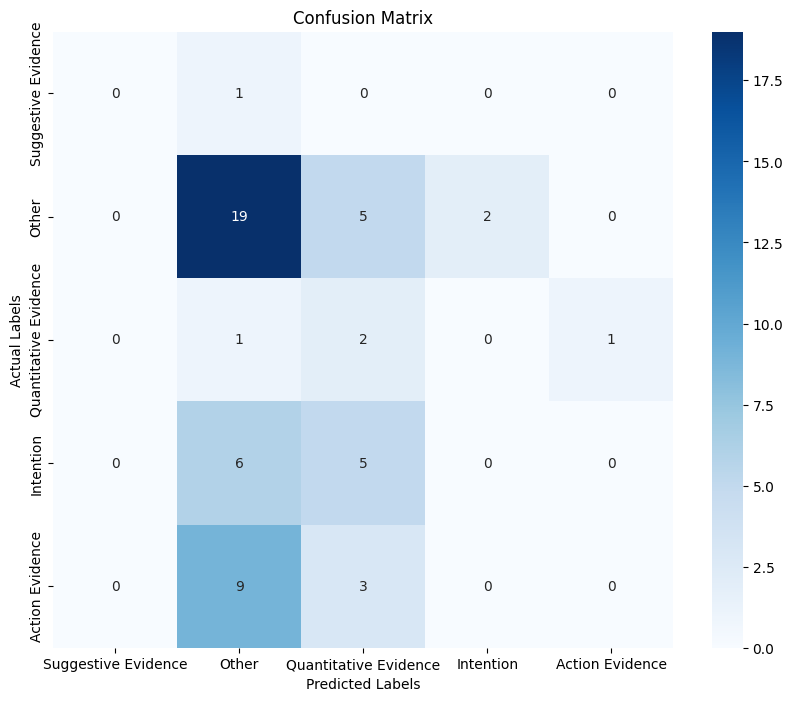

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

accuracy = accuracy_score(df_['labels'], df_['response'])

# Compute confusion matrix
cm = confusion_matrix(df_['labels'], df_['response'], labels=list(set(df_['labels'])))
cm_df = pd.DataFrame(cm, index=list(set(df_['labels'])), columns=list(set(df_['labels'])))

print(f"accuracy : {accuracy}")

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

# Analysis

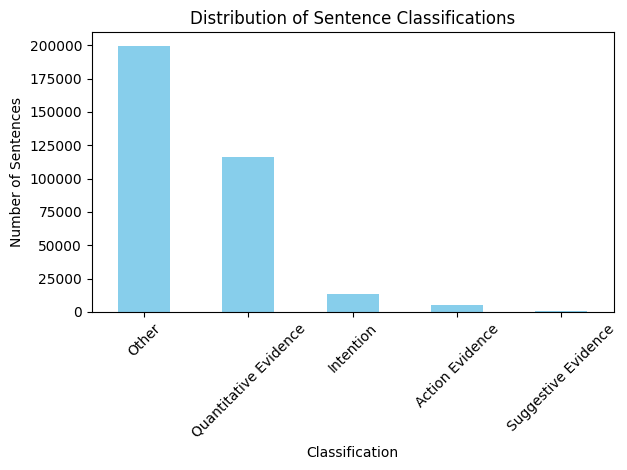

In [27]:
import matplotlib.pyplot as plt
from collections import Counter


# Load the classified sentences CSV
# df = pd.read_csv("classified_sentences.csv")

df = df_export

# Distribution Analysis
classification_counts = df['classification'].value_counts()
classification_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Sentence Classifications')
plt.xlabel('Classification')
plt.ylabel('Number of Sentences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

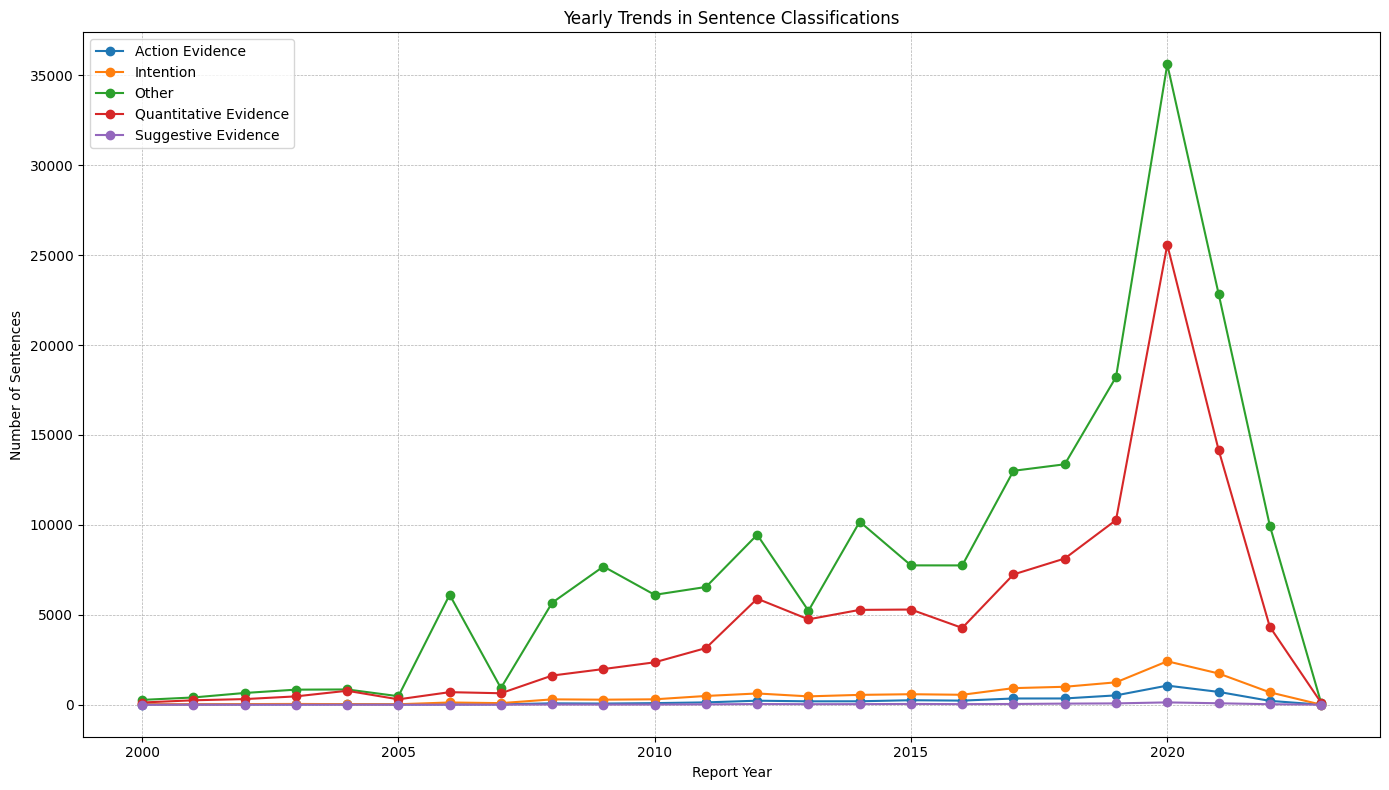

In [28]:
# Yearly trends in classifications
yearly_counts = df.groupby(['report_year', 'classification']).size().unstack().fillna(0)

# Plotting the yearly trends
plt.figure(figsize=(14, 8))
for classification in yearly_counts.columns:
    plt.plot(yearly_counts.index, yearly_counts[classification], label=classification, marker='o')
    
plt.title('Yearly Trends in Sentence Classifications')
plt.xlabel('Report Year')
plt.ylabel('Number of Sentences')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

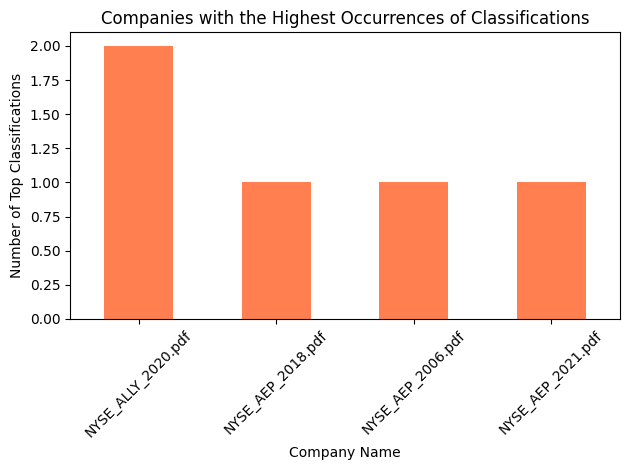

In [29]:
# Company Analysis
top_companies = df.groupby(['company_name', 'classification']).size().unstack().fillna(0)
top_classifications = top_companies.idxmax()
top_classifications.value_counts().plot(kind='bar', color='coral')
plt.title('Companies with the Highest Occurrences of Classifications')
plt.xlabel('Company Name')
plt.ylabel('Number of Top Classifications')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/nv/l4t7vfpj1dd6k81r6lwx7ym80000gn/T/ipykernel_61329/3274887702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentence Length'] = df['sentences'].apply(len)


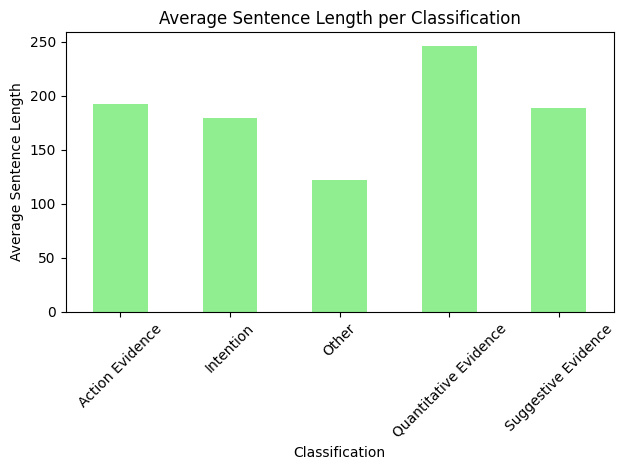

In [30]:
# Sentence Length Analysis
df['Sentence Length'] = df['sentences'].apply(len)
avg_sentence_length = df.groupby('classification')['Sentence Length'].mean()
avg_sentence_length.plot(kind='bar', color='lightgreen')
plt.title('Average Sentence Length per Classification')
plt.xlabel('Classification')
plt.ylabel('Average Sentence Length')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()